# Tree species classification project -- Data Science of Earth Oberservation
Group members:


Input file: .npy

In [1]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 

from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
import torch
# Folium setup.
import folium

# Step 1. Input the npy data

In [2]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0201/npy/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples,)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

4it [00:00, 42.97it/s]


Now all merge samples are saved!


# Step 2. Data preparation

In [3]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)

(1728, 1, 2)
(433, 1, 2)


In [4]:
kernel=24
bands=45
output_size = 5
number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  kernel,kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)



In [5]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]
X_val= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)

In [6]:
number_samples = X_train.shape[0]
X_train_rf = np.reshape(X_train, (number_samples,  kernel*kernel*bands))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)

Post-processed S2_train data shape:  (1728, 25920)


In [7]:
number_samples_v = X_val.shape[0]
X_val_rf = np.reshape(X_val, (number_samples_v, kernel*kernel*bands))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (433, 25920)


# Step 3. Random forest classification

Random Forest: Random Forest is a supervised learning algorithm, it can be used to classify tree species using Sentinel-2 imagery.

In [8]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [9]:
y_pred_rf = rf_classifier.predict(X_val_rf)

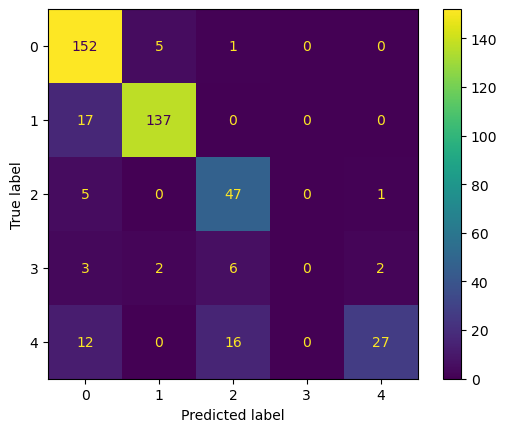

Accuracy Random Forest Classifier:  0.8383371824480369


In [10]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

# Step 4. Artificial Nueral Network (ANN) classification

In [11]:
number_samples = X_train.shape[0]
X_train_nn= np.zeros((number_samples,  kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn[i,:] = np.reshape(X_train[i,:], (  kernel*kernel,bands))
    X_train_nn[i,:]= np.array(pd.DataFrame(X_train_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn.shape)

Post-processed S2_train data shape:  (1728, 576, 45)


In [12]:
number_samples = X_train.shape[0]
X_train_nn0= np.zeros((number_samples,  kernel,4,kernel,bands), dtype=float)
X_train_nn1= np.zeros((number_samples,  kernel*4,kernel,4,bands), dtype=float)
X_train_nn2= np.zeros((number_samples,  kernel*4,kernel,bands), dtype=float)
X_train_nn3= np.zeros((number_samples,  kernel*4,kernel*4,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn0[i,:] = np.stack((np.array(X_train[i,:]),np.array(X_train[i,:]),np.array(X_train[i,:]),np.array(X_train[i,:])),axis=1)
    X_train_nn2[i,:] = np.reshape(X_train_nn0[i,:], (  kernel*4,kernel,bands))
    X_train_nn1[i,:] = np.stack((np.array(X_train_nn2[i,:]),np.array(X_train_nn2[i,:]),np.array(X_train_nn2[i,:]),np.array(X_train_nn2[i,:])),axis=2)
    
    X_train_nn3[i,:] = np.reshape(X_train_nn1[i,:], (  kernel*4,kernel*4,bands))
   # X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
    #X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn3.shape)

Post-processed S2_train data shape:  (1728, 96, 96, 45)


In [13]:
number_samples = X_val.shape[0]
X_val_nn0= np.zeros((number_samples,  kernel,4,kernel,bands), dtype=float)
X_val_nn1= np.zeros((number_samples,  kernel*4,kernel,4,bands), dtype=float)
X_val_nn2= np.zeros((number_samples,  kernel*4,kernel,bands), dtype=float)
X_val_nn3= np.zeros((number_samples,  kernel*4,kernel*4,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn0[i,:] = np.stack((np.array(X_val[i,:]),np.array(X_val[i,:]),np.array(X_val[i,:]),np.array(X_val[i,:])),axis=1)
    X_val_nn2[i,:] = np.reshape(X_val_nn0[i,:], (  kernel*4,kernel,bands))
    X_val_nn1[i,:] = np.stack((np.array(X_val_nn2[i,:]),np.array(X_val_nn2[i,:]),np.array(X_val_nn2[i,:]),np.array(X_val_nn2[i,:])),axis=2)
    
    X_val_nn3[i,:] = np.reshape(X_val_nn1[i,:], (  kernel*4,kernel*4,bands))
   # X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
    #X_train_nn2[i,:]= np.array(pd.DataFrame(X_train_nn2[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_val_nn3.shape)

Post-processed S2_train data shape:  (433, 96, 96, 45)


In [14]:
input_size=( kernel*kernel,bands)

In [15]:
number_samples = X_val.shape[0]
X_val_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn[i,:] = np.reshape(X_val[i,:], (  kernel*kernel,bands))
    X_val_nn[i,:]= np.array(pd.DataFrame(X_val_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_val_nn.shape)

Post-processed S2_train data shape:  (433, 576, 45)


In [17]:
base_model =tf.keras.applications.MobileNetV2(
                                               include_top=False,
                                               weights='imagenet',
                                               input_tensor=None,input_shape=(  kernel*kernel,bands,3), pooling=None, classes=output_size)
   
    

base_model.trainable = False
base_learning_rate = 0.0001

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-02 01:38:41.519005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-02 01:38:41.521115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=input_size),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(output_size, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [20]:
history = simple_model.fit(X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0,validation_data=(X_val_nn, Y_val))

Epoch 1/140


2023-02-02 01:38:51.695594: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-02 01:38:51.843696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 19ms/sample - loss: 3.4037 - accuracy: 0.4433 - val_loss: 0.8845 - val_accuracy: 0.6651


2023-02-02 01:38:52.628557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 21/140
54/54 [==============================] - 1s 10ms/sample - loss: 0.7475 - accuracy: 0.6291 - val_loss: 0.6540 - val_accuracy: 0.7252
Epoch 41/140
54/54 [==============================] - 1s 10ms/sample - loss: 0.7122 - accuracy: 0.6834 - val_loss: 0.7083 - val_accuracy: 0.6998
Epoch 61/140
54/54 [==============================] - 1s 10ms/sample - loss: 0.6167 - accuracy: 0.7234 - val_loss: 0.5370 - val_accuracy: 0.7737
Epoch 81/140
54/54 [==============================] - 1s 10ms/sample - loss: 0.5300 - accuracy: 0.7627 - val_loss: 0.5707 - val_accuracy: 0.7829
Epoch 101/140
54/54 [==============================] - 1s 10ms/sample - loss: 0.6711 - accuracy: 0.7459 - val_loss: 0.5752 - val_accuracy: 0.7760
Epoch 121/140
54/54 [==============================] - 1s 10ms/sample - loss: 0.5761 - accuracy: 0.7853 - val_loss: 0.6579 - val_accuracy: 0.7667


In [21]:
y_pred_dl_p = simple_model.predict(X_val_nn)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

14/14 [==============================] - 0s 6ms/step
Prediction example:  [7.9351240e-01 2.0313257e-01 1.0584307e-07 4.1168221e-08 3.3549545e-03]  Class:  0


2023-02-02 01:40:08.801518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


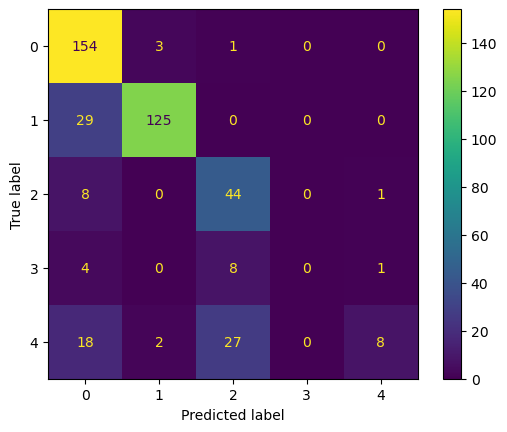

Accuracy Simple Deep Learning model:  0.7644341801385681


In [22]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

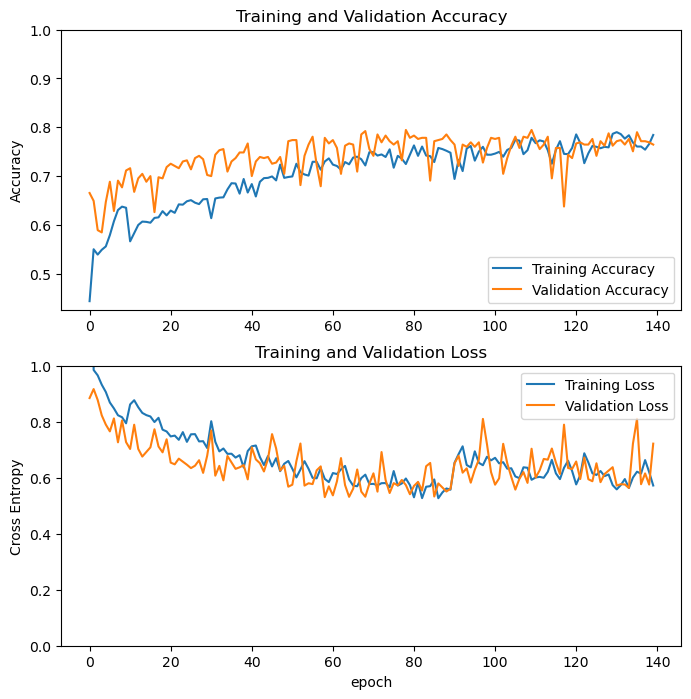

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

simple_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
simple_model.summary()
len(simple_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25920)             0         
                                                                 
 dense (Dense)               (None, 128)               3317888   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 3,318,533
Trainable params: 3,318,533
Non-trainable params: 0
_________________________________________________________________


4

In [26]:
fine_tune_epochs = 140
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = simple_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 140/150
54/54 [==============================] - 1s 13ms/step - loss: 0.5302 - accuracy: 0.7969 - val_loss: 0.5724 - val_accuracy: 0.7737
Epoch 141/150
54/54 [==============================] - 1s 12ms/step - loss: 0.5157 - accuracy: 0.8067 - val_loss: 0.5679 - val_accuracy: 0.7760
Epoch 142/150
54/54 [==============================] - 1s 12ms/step - loss: 0.5457 - accuracy: 0.7963 - val_loss: 0.5727 - val_accuracy: 0.7737
Epoch 143/150
54/54 [==============================] - 1s 12ms/step - loss: 0.5373 - accuracy: 0.7963 - val_loss: 0.5691 - val_accuracy: 0.7760
Epoch 144/150
54/54 [==============================] - 1s 12ms/step - loss: 0.5185 - accuracy: 0.8073 - val_loss: 0.5706 - val_accuracy: 0.7783
Epoch 145/150
54/54 [==============================] - 1s 12ms/step - loss: 0.5178 - accuracy: 0.8056 - val_loss: 0.5680 - val_accuracy: 0.7714
Epoch 146/150
54/54 [==============================] - 1s 12ms/step - loss: 0.5242 - accuracy: 0.8038 - val_loss: 0.5716 - val_accuracy:

In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

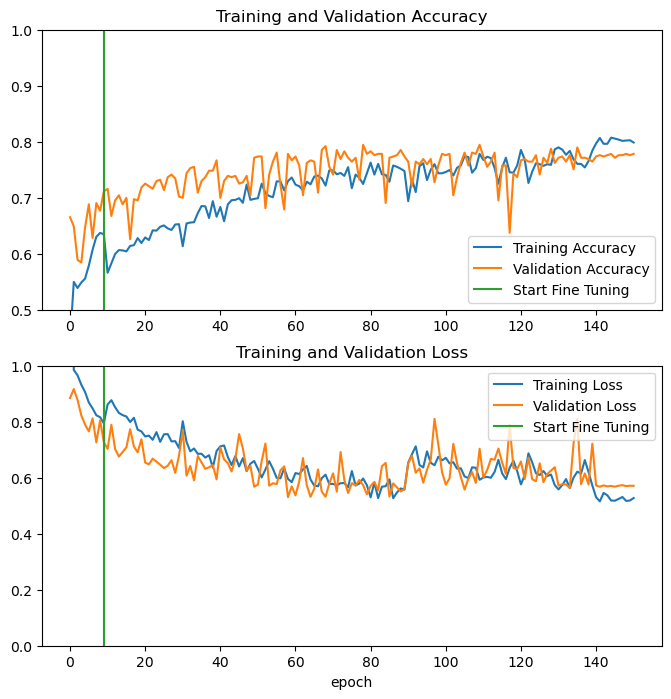

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
loss, accuracy = simple_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

14/14 [==============================] - 0s 8ms/step - loss: 0.5711 - accuracy: 0.7783
Test accuracy : 0.7782909870147705


# Step 5. Convolutional Neural Networks (CNNs) classification

Convolutional Neural Networks (CNNs): These are commonly used for image classification tasks and have been shown to be effective for tree species classification using Sentinel-2 imagery.

In [30]:
CNNs_model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(kernel*kernel,bands,1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (1,1), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
    
]
)

In [31]:

CNNs_model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 576, 45, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 288, 22, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 288, 22, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 144, 11, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 11, 128)      8320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 72, 5, 128)      

In [32]:

CNNs_model.add(layers.Flatten())
CNNs_model.add(layers.Dense(64, activation='relu'))
CNNs_model.add(layers.Dropout(0.5))
CNNs_model.add(layers.Dense(output_size))

In [33]:

CNNs_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 576, 45, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 288, 22, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 288, 22, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 144, 11, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 11, 128)      8320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 72, 5, 128)      

In [34]:

CNNs_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = CNNs_model.fit(X_train_nn, Y_train, epochs=30,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10)],  verbose=0,
                    validation_data=(X_val_nn, Y_val))
     

Epoch 1/30


2023-02-02 01:41:38.870008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-02 01:41:42.970942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 5s 88ms/sample - loss: 1.2749 - accuracy: 0.4271 - val_loss: 0.9813 - val_accuracy: 0.4550
Epoch 11/30
54/54 [==============================] - 3s 52ms/sample - loss: 0.4814 - accuracy: 0.8119 - val_loss: 0.5124 - val_accuracy: 0.7875
Epoch 21/30
54/54 [==============================] - 3s 53ms/sample - loss: 0.2531 - accuracy: 0.8981 - val_loss: 0.6132 - val_accuracy: 0.8014


In [35]:
y_pred_cnn_p = CNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

 6/14 [===========>..................] - ETA: 0s

2023-02-02 01:43:09.368839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 21ms/step
Prediction example:  [ 7.2171597  0.3448073 -8.008871  -8.729743  -4.0764914]  Class:  0


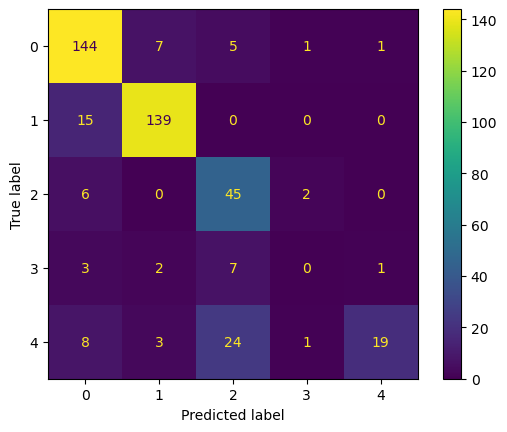

Accuracy Simple Deep Learning model:  0.8013856812933026


In [36]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

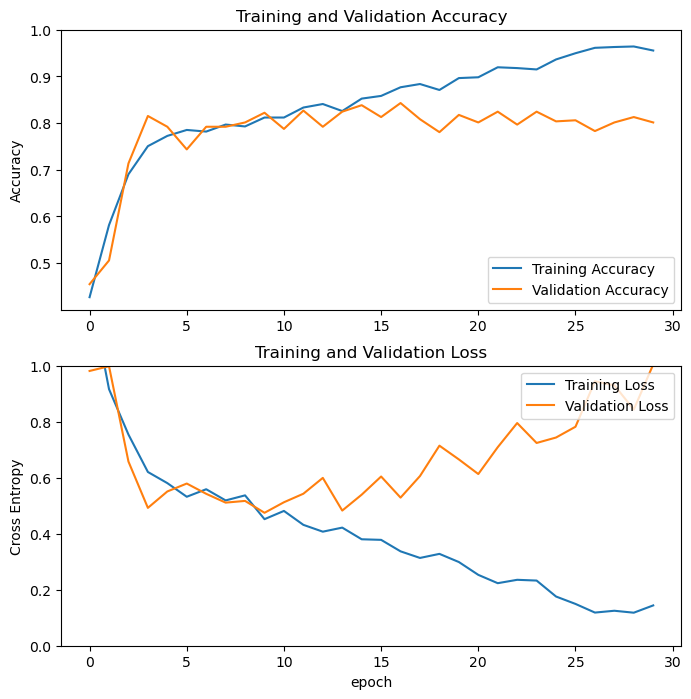

In [37]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

CNNs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
CNNs_model.summary()
len(CNNs_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 576, 45, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 288, 22, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 288, 22, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 144, 11, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 11, 128)      8320      
                                                                 
 max_pooling2

14

In [39]:

fine_tune_epochs = 30
initial_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = CNNs_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs,
                         initial_epoch=history2.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 30/40


2023-02-02 01:43:22.560687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/54 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9782

2023-02-02 01:43:26.259112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 63ms/step - loss: 0.0788 - accuracy: 0.9786 - val_loss: 0.9091 - val_accuracy: 0.8060
Epoch 31/40
54/54 [==============================] - 3s 55ms/step - loss: 0.0687 - accuracy: 0.9832 - val_loss: 0.9080 - val_accuracy: 0.8106
Epoch 32/40
54/54 [==============================] - 3s 55ms/step - loss: 0.0558 - accuracy: 0.9861 - val_loss: 0.9179 - val_accuracy: 0.8129
Epoch 33/40
54/54 [==============================] - 3s 56ms/step - loss: 0.0544 - accuracy: 0.9907 - val_loss: 0.9277 - val_accuracy: 0.8152
Epoch 34/40
54/54 [==============================] - 3s 55ms/step - loss: 0.0490 - accuracy: 0.9913 - val_loss: 0.9361 - val_accuracy: 0.8129
Epoch 35/40
54/54 [==============================] - 3s 56ms/step - loss: 0.0478 - accuracy: 0.9902 - val_loss: 0.9435 - val_accuracy: 0.8106
Epoch 36/40
54/54 [==============================] - 3s 55ms/step - loss: 0.0453 - accuracy: 0.9913 - val_loss: 0.9591 - val_accuracy: 0.8106
Epoch 37/40
54/54 

In [40]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

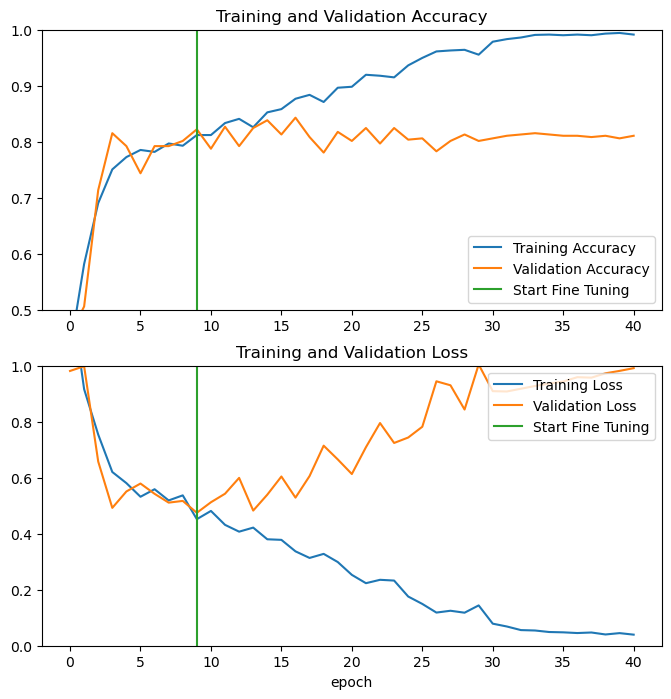

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
loss, accuracy = CNNs_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

14/14 [==============================] - 1s 33ms/step - loss: 0.9913 - accuracy: 0.8106
Test accuracy : 0.8106235265731812


# Step 6. - Residual Network: ResNet

A residual neural network (ResNet) is an artificial neural network that imitate the pyramidal cells in the cerebral cortex. Particularly, the ResNet architecture consists of skip connections or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. These *cells* are known as *residual block*.

ResNets connection weights are easier to optimize (especially for gradient descent-based optimizers) because the short cuts contribute to alleviate the vanishing gradient problem.

In practice, the degradation problem (i.e., increasing the depth of a network leads to a decrease in its performance) is mitigated, and the observed performance (when the number of hidden layers increase) is much closer to the theoretical one.

In [43]:
model_rn = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(  kernel*kernel,bands,1), 
    pooling=None,
    classes=output_size)

model_rn.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [44]:
history3=model_rn.fit(X_train_nn, Y_train, epochs=80,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0,validation_data=(X_val_nn, Y_val))


Epoch 1/100


2023-02-02 01:44:48.861066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-02 01:45:10.191905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 25s 469ms/sample - loss: 1.6554 - accuracy: 0.6256 - val_loss: 1.4893 - val_accuracy: 0.3557
Epoch 21/100
54/54 [==============================] - 18s 329ms/sample - loss: 0.5459 - accuracy: 0.7928 - val_loss: 0.7501 - val_accuracy: 0.6882
Epoch 41/100
54/54 [==============================] - 18s 334ms/sample - loss: 0.4145 - accuracy: 0.8438 - val_loss: 1.4899 - val_accuracy: 0.6051
Epoch 61/100
54/54 [==============================] - 18s 329ms/sample - loss: 0.3842 - accuracy: 0.8576 - val_loss: 1.3208 - val_accuracy: 0.8106
Epoch 81/100
54/54 [==============================] - 18s 328ms/sample - loss: 0.3177 - accuracy: 0.8733 - val_loss: 2.0845 - val_accuracy: 0.4758


2023-02-02 02:21:52.584553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 100ms/step


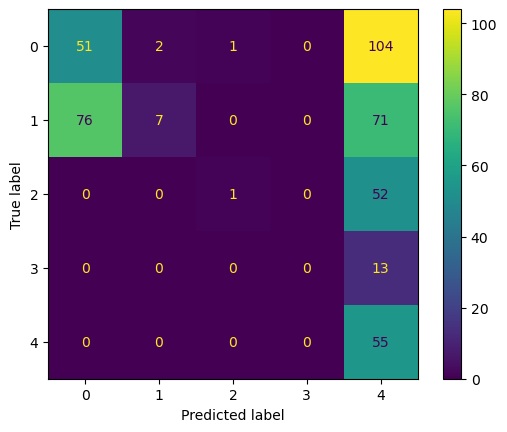

Accuracy ResNet-50 model:  0.2632794457274827


In [45]:
y_pred_rn_p = model_rn.predict(X_val_nn)

y_pred_rn = np.argmax(y_pred_rn_p, axis=1)

##print(y_pred_rn)
#print(Y_val)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rn)
plt.show()

acc_rn = accuracy_score(Y_val, y_pred_rn)
print("Accuracy ResNet-50 model: ", acc_rn)

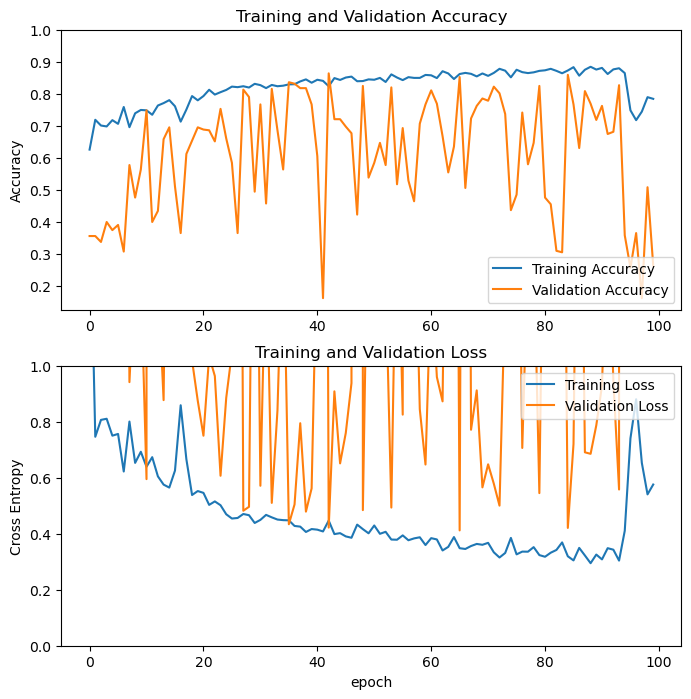

In [46]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model_rn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model_rn.summary()
len(model_rn.trainable_variables)

Number of layers in the base model:  154
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 576, 45, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 582, 51, 1)   0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 288, 23, 64)  3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 288, 23, 64

214

In [48]:
fine_tune_epochs = 100
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_rn.fit(X_train_nn,Y_train,
                         epochs=total_epochs,
                         initial_epoch=history3.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 100/110


/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-02-02 02:22:34.562242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 0.7527 - accuracy: 0.7251

2023-02-02 02:23:03.613406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 35s 409ms/step - loss: 0.7527 - accuracy: 0.7251 - val_loss: 1.4850 - val_accuracy: 0.5889
Epoch 101/110
54/54 [==============================] - 19s 349ms/step - loss: 0.6915 - accuracy: 0.7361 - val_loss: 0.8743 - val_accuracy: 0.6813
Epoch 102/110
54/54 [==============================] - 19s 353ms/step - loss: 0.6735 - accuracy: 0.7494 - val_loss: 0.6053 - val_accuracy: 0.7529
Epoch 103/110
54/54 [==============================] - 19s 355ms/step - loss: 0.6415 - accuracy: 0.7402 - val_loss: 0.5693 - val_accuracy: 0.7575
Epoch 104/110
54/54 [==============================] - 19s 354ms/step - loss: 0.6146 - accuracy: 0.7494 - val_loss: 0.5680 - val_accuracy: 0.7737
Epoch 105/110
54/54 [==============================] - 19s 348ms/step - loss: 0.5930 - accuracy: 0.7662 - val_loss: 0.5710 - val_accuracy: 0.7783
Epoch 106/110
54/54 [==============================] - 19s 351ms/step - loss: 0.5860 - accuracy: 0.7726 - val_loss: 0.5673 - val_accuracy:

In [49]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

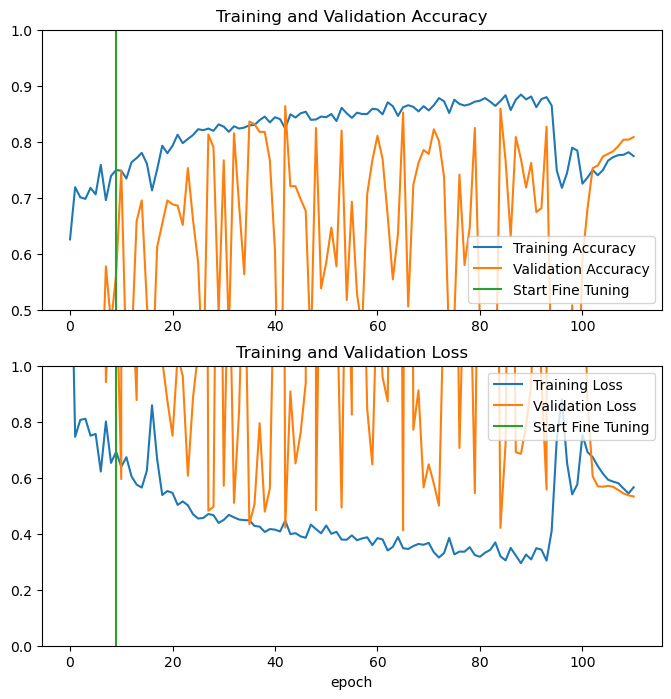

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Step 7. Recurrent Neural Networks (RNNs) classification

Recurrent Neural Networks (RNNs): RNNs can be used to analyze sequential data such as time series data, which can be useful for analyzing the temporal information present in Sentinel-2 imagery.

In [51]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = bands

units = 64


# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(kernel*kernel, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(kernel*kernel, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [52]:
RNNs_model = build_model(allow_cudnn_kernel=True)

RNNs_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


history5=RNNs_model.fit(
    X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0, validation_data=(X_val_nn, Y_val), batch_size=batch_size
)

Epoch 1/100


2023-02-02 02:27:18.656245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-02 02:27:18.806566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-02 02:27:21.146539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-02 02:27:28.953749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-02 02:27:29.042039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 14s 500ms/sample - loss: 1.4549 - accuracy: 0.4659 - val_loss: 1.4903 - val_accuracy: 0.3880
Epoch 21/100
27/27 [==============================] - 4s 154ms/sample - loss: 0.7648 - accuracy: 0.7170 - val_loss: 1.0630 - val_accuracy: 0.5612
Epoch 41/100
27/27 [==============================] - 4s 150ms/sample - loss: 0.6650 - accuracy: 0.7488 - val_loss: 1.8407 - val_accuracy: 0.5358
Epoch 61/100
27/27 [==============================] - 4s 156ms/sample - loss: 0.5741 - accuracy: 0.7691 - val_loss: 1.3738 - val_accuracy: 0.6374
Epoch 81/100
27/27 [==============================] - 4s 155ms/sample - loss: 0.5277 - accuracy: 0.7928 - val_loss: 1.1259 - val_accuracy: 0.7252


In [53]:
y_pred_rnn_p = RNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_rnn_p[0,:], " Class: ", np.argmax(y_pred_rnn_p[0,:]))

2023-02-02 03:01:31.144753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-02 03:01:31.306882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 4s 160ms/step
Prediction example:  [  9.948249   11.880403   -2.3108668  -5.0341463 -10.668794 ]  Class:  1


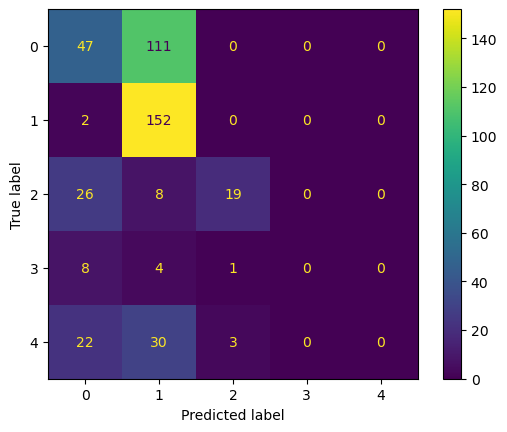

Accuracy Simple Deep Learning model:  0.5034642032332564


In [54]:
y_pred_rnn = np.argmax(y_pred_rnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_rnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

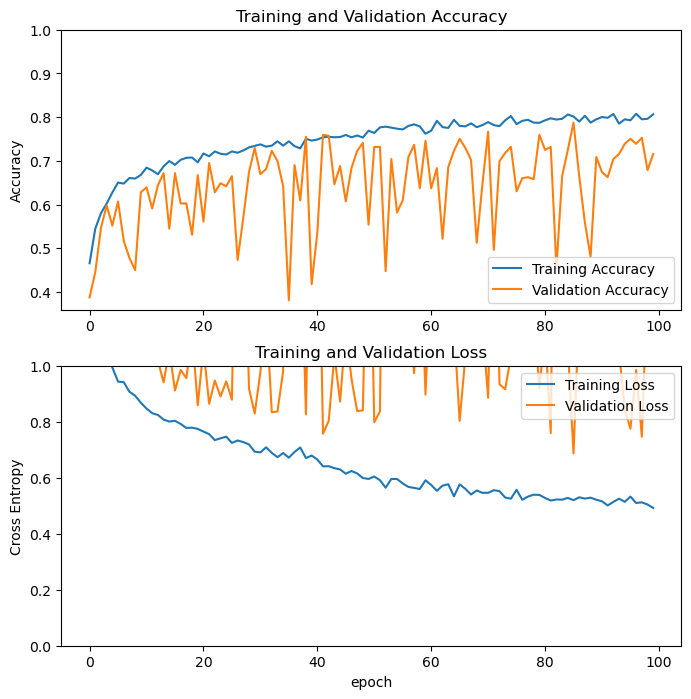

In [55]:

acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

RNNs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
RNNs_model.summary()
len(RNNs_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                28160     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_6 (Dense)             (None, 5)                 325       
                                                                 
Total params: 28,741
Trainable params: 28,613
Non-trainable params: 128
_________________________________________________________________


7

In [57]:
fine_tune_epochs = 100
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = RNNs_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs,
                         initial_epoch=history5.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 100/110


2023-02-02 03:01:47.725500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-02 03:01:47.892207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-02 03:01:49.675098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 0.9669 - accuracy: 0.7170

2023-02-02 03:01:59.585749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-02 03:01:59.679925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 16s 193ms/step - loss: 0.9669 - accuracy: 0.7170 - val_loss: 1.9683 - val_accuracy: 0.6259
Epoch 101/110
54/54 [==============================] - 8s 148ms/step - loss: 0.8451 - accuracy: 0.7384 - val_loss: 1.1796 - val_accuracy: 0.7182
Epoch 102/110
54/54 [==============================] - 8s 146ms/step - loss: 0.7368 - accuracy: 0.7581 - val_loss: 0.8828 - val_accuracy: 0.7644
Epoch 103/110
54/54 [==============================] - 8s 146ms/step - loss: 0.6571 - accuracy: 0.7784 - val_loss: 0.7649 - val_accuracy: 0.7691
Epoch 104/110
54/54 [==============================] - 8s 148ms/step - loss: 0.6278 - accuracy: 0.7859 - val_loss: 0.6956 - val_accuracy: 0.7829
Epoch 105/110
54/54 [==============================] - 8s 147ms/step - loss: 0.5889 - accuracy: 0.7940 - val_loss: 0.6692 - val_accuracy: 0.7968
Epoch 106/110
54/54 [==============================] - 8s 146ms/step - loss: 0.5657 - accuracy: 0.7934 - val_loss: 0.6527 - val_accuracy: 0.796

In [58]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

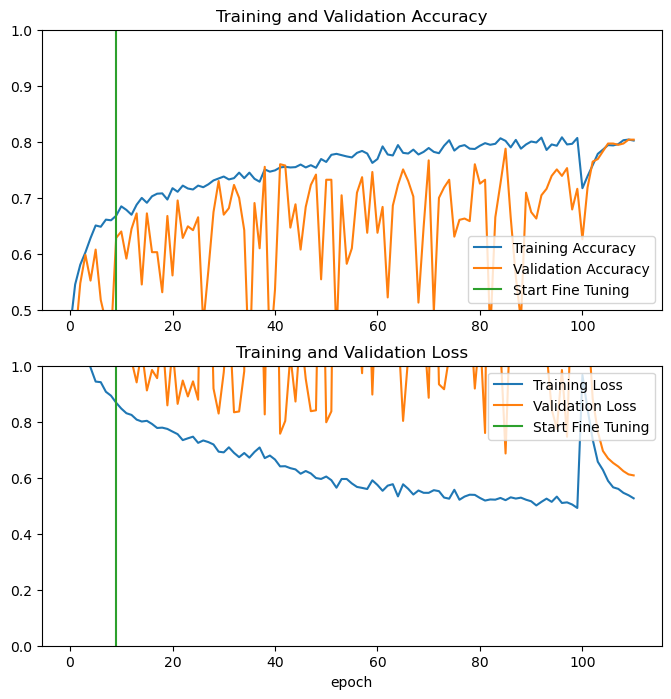

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Step 8. Decision fusion for deep learning methods

In [60]:

y_pred_dl_p_2 = simple_model.predict(X_val_nn)
y_pred_cnn_p_2 = CNNs_model.predict(X_val_nn)
y_pred_rn_p_2 = model_rn.predict(X_val_nn)
y_pred_rnn_p_2 = RNNs_model.predict(X_val_nn)

14/14 [==============================] - 0s 8ms/step


2023-02-02 03:03:46.818939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/14 [=>............................] - ETA: 1s

2023-02-02 03:03:47.086232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 58ms/step


2023-02-02 03:03:48.377964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 102ms/step


2023-02-02 03:03:50.692807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-02 03:03:50.744995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 3s 157ms/step


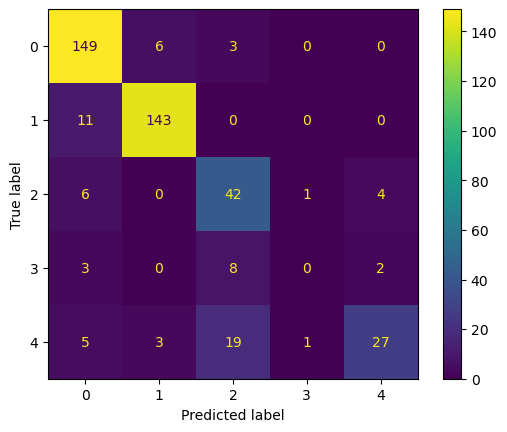

Accuracy Simple Deep Learning model:  0.8337182448036952


In [63]:

#fusion"""y_pred_dl_p_2 +
fusion_softmax =  y_pred_cnn_p_2 + y_pred_rn_p_2 + y_pred_rnn_p_2
fusion_label = np.argmax(fusion_softmax,axis=1).astype(np.int16)
ConfusionMatrixDisplay.from_predictions(Y_val, fusion_label)
plt.show()

acc_dl = accuracy_score(Y_val, fusion_label)
print("Accuracy Simple Deep Learning model: ", acc_dl)